In [ ]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.5.1+cu124
2.5.1+cu124
cuda


In [ ]:
from dataclasses import dataclass

import IPython
import matplotlib.pyplot as plt

torch.random.manual_seed(0)

SPEECH_FILE = "happy.wav"

## Generate frame-wise label probability

The first step is to generate the label class porbability of each audio
frame. We can use a Wav2Vec2 model that is trained for ASR. Here we use
:py:func:`torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H`.

``torchaudio`` provides easy access to pretrained models with associated
labels.

<div class="alert alert-info"><h4>Note</h4><p>In the subsequent sections, we will compute the probability in
   log-domain to avoid numerical instability. For this purpose, we
   normalize the ``emission`` with :py:func:`torch.log_softmax`.</p></div>




In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

print(labels)

('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


### Visualization



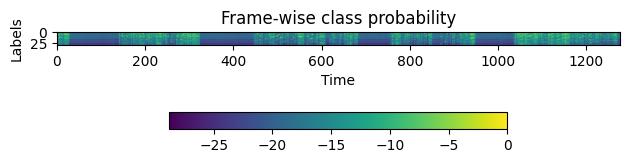

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(emission.T)
    ax.set_title("Frame-wise class probability")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

## Generate alignment probability (trellis)

From the emission matrix, next we generate the trellis which represents
the probability of transcript labels occur at each time frame.

Trellis is 2D matrix with time axis and label axis. The label axis
represents the transcript that we are aligning. In the following, we use
$t$ to denote the index in time axis and $j$ to denote the
index in label axis. $c_j$ represents the label at label index
$j$.

To generate, the probability of time step $t+1$, we look at the
trellis from time step $t$ and emission at time step $t+1$.
There are two path to reach to time step $t+1$ with label
$c_{j+1}$. The first one is the case where the label was
$c_{j+1}$ at $t$ and there was no label change from
$t$ to $t+1$. The other case is where the label was
$c_j$ at $t$ and it transitioned to the next label
$c_{j+1}$ at $t+1$.

The follwoing diagram illustrates this transition.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/ctc-forward.png">

Since we are looking for the most likely transitions, we take the more
likely path for the value of $k_{(t+1, j+1)}$, that is

$k_{(t+1, j+1)} = max( k_{(t, j)} p(t+1, c_{j+1}), k_{(t, j+1)} p(t+1, repeat) )$

where $k$ represents is trellis matrix, and $p(t, c_j)$
represents the probability of label $c_j$ at time step $t$.
$repeat$ represents the blank token from CTC formulation. (For the
detail of CTC algorithm, please refer to the *Sequence Modeling with CTC*
[[distill.pub](https://distill.pub/2017/ctc/)_])




In [ ]:
import string

def transform_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.upper().replace(" ", "|")  # Convert to uppercase and replace spaces with |
    return f"|{text}|"

# Example usage
input_text = "Hello, world! This is a test."
output_text = transform_text(input_text)
print(output_text)  # Output: |HELLO|WORLD|THIS|IS|A|TEST|


|HELLO|WORLD|THIS|IS|A|TEST|


In [ ]:
transcript="Hello! This is a test for text-to-speech synthesis. Each word should be clear, smooth, and natural. Check pronunciation, speed, and tone. Let's ensure the voice sounds realistic and engaging!"
transcript=transform_text(transcript)
print(transcript)

|HELLO|THIS|IS|A|TEST|FOR|TEXTTOSPEECH|SYNTHESIS|EACH|WORD|SHOULD|BE|CLEAR|SMOOTH|AND|NATURAL|CHECK|PRONUNCIATION|SPEED|AND|TONE|LETS|ENSURE|THE|VOICE|SOUNDS|REALISTIC|AND|ENGAGING|


In [ ]:
# We enclose the transcript with space tokens, which represent SOS and EOS.

dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    trellis = torch.zeros((num_frame, num_tokens))
    trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")

    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emission, tokens)

[('|', 1), ('H', 8), ('E', 2), ('L', 12), ('L', 12), ('O', 5), ('|', 1), ('T', 3), ('H', 8), ('I', 7), ('S', 9), ('|', 1), ('I', 7), ('S', 9), ('|', 1), ('A', 4), ('|', 1), ('T', 3), ('E', 2), ('S', 9), ('T', 3), ('|', 1), ('F', 17), ('O', 5), ('R', 10), ('|', 1), ('T', 3), ('E', 2), ('X', 25), ('T', 3), ('T', 3), ('O', 5), ('S', 9), ('P', 20), ('E', 2), ('E', 2), ('C', 16), ('H', 8), ('|', 1), ('S', 9), ('Y', 19), ('N', 6), ('T', 3), ('H', 8), ('E', 2), ('S', 9), ('I', 7), ('S', 9), ('|', 1), ('E', 2), ('A', 4), ('C', 16), ('H', 8), ('|', 1), ('W', 15), ('O', 5), ('R', 10), ('D', 11), ('|', 1), ('S', 9), ('H', 8), ('O', 5), ('U', 13), ('L', 12), ('D', 11), ('|', 1), ('B', 21), ('E', 2), ('|', 1), ('C', 16), ('L', 12), ('E', 2), ('A', 4), ('R', 10), ('|', 1), ('S', 9), ('M', 14), ('O', 5), ('O', 5), ('T', 3), ('H', 8), ('|', 1), ('A', 4), ('N', 6), ('D', 11), ('|', 1), ('N', 6), ('A', 4), ('T', 3), ('U', 13), ('R', 10), ('A', 4), ('L', 12), ('|', 1), ('C', 16), ('H', 8), ('E', 2), ('C'

### Visualization



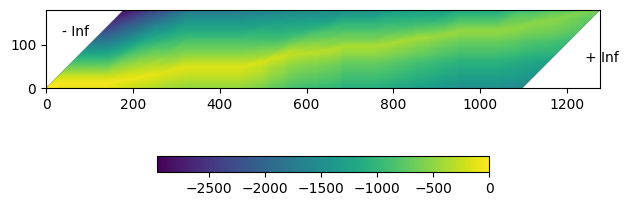

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In the above visualization, we can see that there is a trace of high
probability crossing the matrix diagonally.




## Find the most likely path (backtracking)

Once the trellis is generated, we will traverse it following the
elements with high probability.

We will start from the last label index with the time step of highest
probability, then, we traverse back in time, picking stay
($c_j \rightarrow c_j$) or transition
($c_j \rightarrow c_{j+1}$), based on the post-transition
probability $k_{t, j} p(t+1, c_{j+1})$ or
$k_{t, j+1} p(t+1, repeat)$.

Transition is done once the label reaches the beginning.

The trellis matrix is used for path-finding, but for the final
probability of each segment, we take the frame-wise probability from
emission matrix.




In [ ]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        # assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

Point(token_index=0, time_index=0, score=0.9432530403137207)
Point(token_index=1, time_index=1, score=0.9997969269752502)
Point(token_index=1, time_index=2, score=0.999772846698761)
Point(token_index=1, time_index=3, score=0.9997988343238831)
Point(token_index=1, time_index=4, score=0.5149829387664795)
Point(token_index=2, time_index=5, score=0.977530300617218)
Point(token_index=3, time_index=6, score=0.9534043073654175)
Point(token_index=3, time_index=7, score=0.9989351630210876)
Point(token_index=3, time_index=8, score=0.9952990412712097)
Point(token_index=3, time_index=9, score=0.991596519947052)
Point(token_index=4, time_index=10, score=0.9927566647529602)
Point(token_index=4, time_index=11, score=0.9973026514053345)
Point(token_index=4, time_index=12, score=0.999660849571228)
Point(token_index=4, time_index=13, score=0.9997575879096985)
Point(token_index=4, time_index=14, score=0.9997468590736389)
Point(token_index=4, time_index=15, score=0.9997311234474182)
Point(token_index=4, t

Looking good.



## Segment the path
Now this path contains repetations for the same labels, so
let’s merge them to make it close to the original transcript.

When merging the multiple path points, we simply take the average
probability for the merged segments.




In [ ]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

|	(0.94): [    0,     1)
H	(0.88): [    1,     5)
E	(0.98): [    5,     6)
L	(0.98): [    6,    10)
L	(0.79): [   10,    25)
O	(1.00): [   25,    26)
|	(0.00): [   26,    27)
T	(0.97): [   27,   143)
H	(0.82): [  143,   148)
I	(0.92): [  148,   149)
S	(0.76): [  149,   153)
|	(1.00): [  153,   158)
I	(1.00): [  158,   160)
S	(0.71): [  160,   163)
|	(0.00): [  163,   164)
A	(1.00): [  164,   165)
|	(0.67): [  165,   180)
T	(0.97): [  180,   187)
E	(0.95): [  187,   191)
S	(0.76): [  191,   195)
T	(0.62): [  195,   200)
|	(1.00): [  200,   203)
F	(0.98): [  203,   208)
O	(0.97): [  208,   210)
R	(0.75): [  210,   214)
|	(1.00): [  214,   218)
T	(0.98): [  218,   224)
E	(0.99): [  224,   228)
X	(0.88): [  228,   234)
T	(0.71): [  234,   241)
T	(1.00): [  241,   246)
O	(0.70): [  246,   252)
S	(0.83): [  252,   258)
P	(0.75): [  258,   262)
E	(0.99): [  262,   267)
E	(0.75): [  267,   271)
C	(0.55): [  271,   273)
H	(0.80): [  273,   278)
|	(0.75): [  278,   282)
S	(0.82): [  282,   287)


In [ ]:
# Merge words
word_list=[]
def merge_words(segments, separator="|"):
    words = []
    word_dict={}
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
                word_dict={"word":word,"start":segments[i1].start,"end":segments[i2 - 1].end,"score":score}
                word_list.append(word_dict)
            i1 = i2 + 1

            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

HELLO	(0.85): [    1,    26)
THIS	(0.96): [   27,   153)
IS	(0.83): [  158,   163)
A	(1.00): [  164,   165)
TEST	(0.84): [  180,   200)
FOR	(0.90): [  203,   214)
TEXTTOSPEECH	(0.84): [  218,   278)
SYNTHESIS	(0.87): [  282,   323)
EACH	(0.80): [  452,   465)
WORD	(0.93): [  473,   494)
SHOULD	(0.70): [  498,   512)
BE	(0.93): [  517,   524)
CLEAR	(0.62): [  532,   558)
SMOOTH	(0.82): [  568,   608)
AND	(0.66): [  625,   631)
NATURAL	(0.79): [  643,   680)
CHECK	(0.90): [  760,   779)
PRONUNCIATION	(0.91): [  788,   849)
SPEED	(0.82): [  870,   901)
AND	(0.80): [  914,   919)
TONE	(0.84): [  926,   947)
LETS	(0.85): [ 1038,  1053)
ENSURE	(0.95): [ 1060,  1089)
THE	(0.97): [ 1093,  1099)
VOICE	(0.92): [ 1103,  1126)
SOUNDS	(0.87): [ 1134,  1163)
REALISTIC	(0.88): [ 1168,  1212)
AND	(0.69): [ 1220,  1226)
ENGAGING	(0.93): [ 1230,  1268)


In [ ]:
print(word_list)

[{'word': 'HELLO', 'start': 1, 'end': 26, 'score': 0.8503632512781769}, {'word': 'THIS', 'start': 27, 'end': 153, 'score': 0.9605140121309743}, {'word': 'IS', 'start': 158, 'end': 163, 'score': 0.8258350193500519}, {'word': 'A', 'start': 164, 'end': 165, 'score': 0.9999334812164307}, {'word': 'TEST', 'start': 180, 'end': 200, 'score': 0.8374181389808655}, {'word': 'FOR', 'start': 203, 'end': 214, 'score': 0.8954016860913147}, {'word': 'TEXTTOSPEECH', 'start': 218, 'end': 278, 'score': 0.8384037075937765}, {'word': 'SYNTHESIS', 'start': 282, 'end': 323, 'score': 0.8715000881972473}, {'word': 'EACH', 'start': 452, 'end': 465, 'score': 0.7979762422350737}, {'word': 'WORD', 'start': 473, 'end': 494, 'score': 0.9287084964702704}, {'word': 'SHOULD', 'start': 498, 'end': 512, 'score': 0.6962964545403209}, {'word': 'BE', 'start': 517, 'end': 524, 'score': 0.9307261449950082}, {'word': 'CLEAR', 'start': 532, 'end': 558, 'score': 0.6244580651210316}, {'word': 'SMOOTH', 'start': 568, 'end': 608, 

In [ ]:
import nltk
from nltk.corpus import cmudict

# Download CMU Pronouncing Dictionary (if not already downloaded)
nltk.download("cmudict")

# Load CMU Pronouncing Dictionary
cmu_dict = cmudict.dict()

# Sample input data

# Function to get phonemes from CMU Dictionary
def get_phonemes(word):
    word = word.lower()  # CMU Dictionary uses lowercase words
    return cmu_dict.get(word, [["N/A"]])[0]  # Return phonemes if found, else ["N/A"]

# Add phoneme to each dictionary
for segment in word_list:
    segment["phoneme"] = " ".join(get_phonemes(segment["word"]))

# Print updated list of dictionaries
for segment in word_list:
    print(segment)


[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


{'word': 'HELLO', 'start': 1, 'end': 26, 'score': 0.8503632512781769, 'phoneme': 'HH AH0 L OW1'}
{'word': 'THIS', 'start': 27, 'end': 153, 'score': 0.9605140121309743, 'phoneme': 'DH IH1 S'}
{'word': 'IS', 'start': 158, 'end': 163, 'score': 0.8258350193500519, 'phoneme': 'IH1 Z'}
{'word': 'A', 'start': 164, 'end': 165, 'score': 0.9999334812164307, 'phoneme': 'AH0'}
{'word': 'TEST', 'start': 180, 'end': 200, 'score': 0.8374181389808655, 'phoneme': 'T EH1 S T'}
{'word': 'FOR', 'start': 203, 'end': 214, 'score': 0.8954016860913147, 'phoneme': 'F AO1 R'}
{'word': 'TEXTTOSPEECH', 'start': 218, 'end': 278, 'score': 0.8384037075937765, 'phoneme': 'N/A'}
{'word': 'SYNTHESIS', 'start': 282, 'end': 323, 'score': 0.8715000881972473, 'phoneme': 'S IH1 N TH AH0 S AH0 S'}
{'word': 'EACH', 'start': 452, 'end': 465, 'score': 0.7979762422350737, 'phoneme': 'IY1 CH'}
{'word': 'WORD', 'start': 473, 'end': 494, 'score': 0.9287084964702704, 'phoneme': 'W ER1 D'}
{'word': 'SHOULD', 'start': 498, 'end': 512,

In [ ]:
import torchaudio

# Load the audio file
waveform, sample_rate = torchaudio.load(SPEECH_FILE)

# Get audio duration in milliseconds
audio_duration_ms = (waveform.shape[1] / sample_rate) * 1000  # Convert seconds to ms

# Get the last frame index
max_end_frame = max(segment["end"] for segment in word_list)

# Calculate correct frame duration in ms
frame_duration_ms = audio_duration_ms / max_end_frame

# Convert start/end times to ms using corrected scale
for segment in word_list:
    segment["start_ms"] = int(segment["start"] * frame_duration_ms)
    segment["end_ms"] = int(segment["end"] * frame_duration_ms)

# Print updated list with correct ms values
for segment in word_list:
    print(segment)


{'word': 'HELLO', 'start': 1, 'end': 26, 'score': 0.8503632512781769, 'phoneme': 'HH AH0 L OW1', 'start_ms': 13, 'end_ms': 349}
{'word': 'THIS', 'start': 27, 'end': 153, 'score': 0.9605140121309743, 'phoneme': 'DH IH1 S', 'start_ms': 362, 'end_ms': 2055}
{'word': 'IS', 'start': 158, 'end': 163, 'score': 0.8258350193500519, 'phoneme': 'IH1 Z', 'start_ms': 2122, 'end_ms': 2189}
{'word': 'A', 'start': 164, 'end': 165, 'score': 0.9999334812164307, 'phoneme': 'AH0', 'start_ms': 2203, 'end_ms': 2216}
{'word': 'TEST', 'start': 180, 'end': 200, 'score': 0.8374181389808655, 'phoneme': 'T EH1 S T', 'start_ms': 2418, 'end_ms': 2686}
{'word': 'FOR', 'start': 203, 'end': 214, 'score': 0.8954016860913147, 'phoneme': 'F AO1 R', 'start_ms': 2727, 'end_ms': 2874}
{'word': 'TEXTTOSPEECH', 'start': 218, 'end': 278, 'score': 0.8384037075937765, 'phoneme': 'N/A', 'start_ms': 2928, 'end_ms': 3734}
{'word': 'SYNTHESIS', 'start': 282, 'end': 323, 'score': 0.8715000881972473, 'phoneme': 'S IH1 N TH AH0 S AH0 S

In [ ]:
import json

# Save to a JSON file
with open("word_phonemes.json", "w", encoding="utf-8") as f:
    json.dump(word_list, f, indent=4)

print("JSON file saved as word_phonemes.json")


JSON file saved as word_phonemes.json


/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_axes.py:8233: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


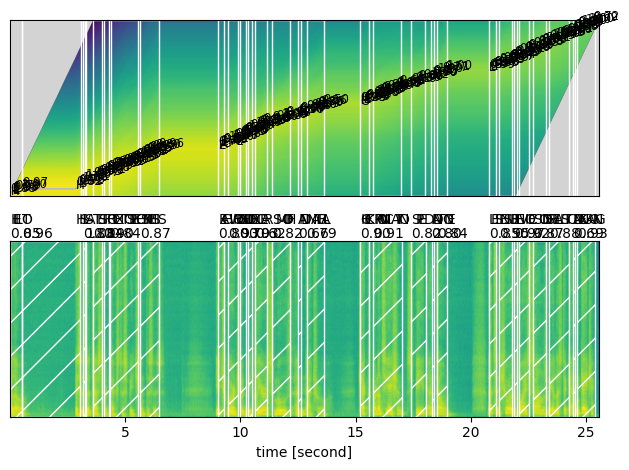

In [ ]:
def plot_alignments(trellis, segments, word_segments, waveform, sample_rate=bundle.sample_rate):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1)

    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")
    ax1.set_facecolor("lightgray")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvspan(word.start - 0.5, word.end - 0.5, edgecolor="white", facecolor="none")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    # The original waveform
    ratio = waveform.size(0) / sample_rate / trellis.size(0)
    ax2.specgram(waveform, Fs=sample_rate)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, facecolor="none", edgecolor="white", hatch="/")
        ax2.annotate(f"{word.score:.2f}", (x0, sample_rate * 0.51), annotation_clip=False)

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, sample_rate * 0.55), annotation_clip=False)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    fig.tight_layout()


plot_alignments(
    trellis,
    segments,
    word_segments,
    waveform[0],
)

## Audio Samples




In [ ]:
def display_segment(i):
    ratio = waveform.size(1) / trellis.size(0)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=bundle.sample_rate)

In [ ]:
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(SPEECH_FILE)

|HELLO|THIS|IS|A|TEST|FOR|TEXTTOSPEECH|SYNTHESIS|EACH|WORD|SHOULD|BE|CLEAR|SMOOTH|AND|NATURAL|CHECK|PRONUNCIATION|SPEED|AND|TONE|LETS|ENSURE|THE|VOICE|SOUNDS|REALISTIC|AND|ENGAGING|


In [ ]:
display_segment(0)

In [ ]:
display_segment(1)

In [ ]:
display_segment(2)

In [ ]:
display_segment(3)

In [ ]:
display_segment(4)

In [ ]:
display_segment(5)

In [ ]:
display_segment(6)

In [ ]:
display_segment(7)

In [ ]:
display_segment(8)

## Conclusion

In this tutorial, we looked how to use torchaudio’s Wav2Vec2 model to
perform CTC segmentation for forced alignment.


